<a href="https://colab.research.google.com/github/kgabriel910/Projects/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Coronary Heart Disease using Blood Data
Created by: Adele Collin and Kyla Gabriel

Course: BMI 715 - Computational Statistics for Biomedical Sciences

Date: 12/15/2023

### Table of Contents
1. Data preprocessing
2. Classification model
3. Hypothesis testing


# Data Preprocessing

In [ ]:
                              ########### Dependencies installation #############
install.packages("ggcorrplot")
install.packages("MASS")
install.packages("glmnet")
install.packages("caret")
install.packages("tidymodels")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘ModelMetrics’, ‘pROC’, ‘recipes’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘furrr’, ‘slider’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘rsample’, ‘tune’, ‘w

In [ ]:
                                    ############## Imports ####################
library(dplyr)
library(tidyr)
library(ggcorrplot)
library(MASS)
library(glmnet)
library(caret)
library(tidymodels)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: lattice

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tibble       3.2.1
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.2.0
✔ recipes      1.0.9     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ─

In [ ]:
                                      ########## Data loading ############
data <- read.csv("/content/nhanes_13_14_subset.csv")
head(data)
cat("The dimensions of the original dataset is", dim(data))

,X,LBXAPB,LBXSAL,LBXSAPSI,LBXSASSI,LBXSATSI,LBXSBU,LBXSC3SI,LBXSCA,LBXSCH,⋯,BPXML1,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BPXSY3,BPXDI3,BPXSY4,BPXDI4,BMXBMI
,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,1,NA,4.1,129,16,16,10,27,9.5,168,⋯,140,122,72,114,76,102,74,NA,NA,26.7
2,2,NA,4.7,97,18,29,16,23,9.2,167,⋯,170,156,62,160,80,156,42,NA,NA,28.6
3,3,57,3.7,99,22,16,14,23,8.9,127,⋯,160,140,90,140,76,146,80,NA,NA,28.9
4,4,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,130,108,38,102,34,104,38,NA,NA,17.1
5,5,92,4.3,78,36,28,31,31,10.0,207,⋯,170,136,86,134,88,142,86,NA,NA,19.7
6,6,NA,4.3,95,24,16,18,25,9.3,230,⋯,180,160,84,158,82,154,80,NA,NA,41.7


The dimensions of the original dataset is 10175 414

In [ ]:
                            ######## Preprocessing of the data #########

curated_data <-data[rowMeans(is.na(data)) <= 0.6,]
curated_data <- curated_data[,colMeans(is.na(curated_data)) < 0.3]
curated_data <- curated_data[, -c(1)]
for(i in colnames(curated_data)){
  curated_data[is.na(curated_data[,i]), i] <- median(curated_data[,i], na.rm = TRUE) #replace the NA value by the mean
}
dim(curated_data)

[1] 4408  152

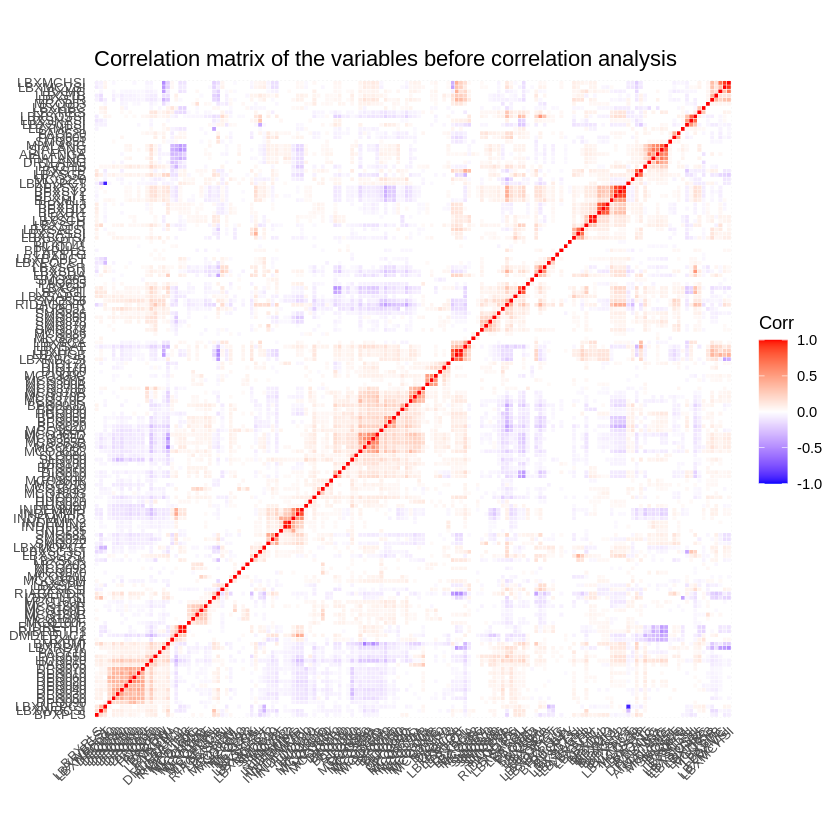

The dimensions of the dataset after the correlation step is 4408 75

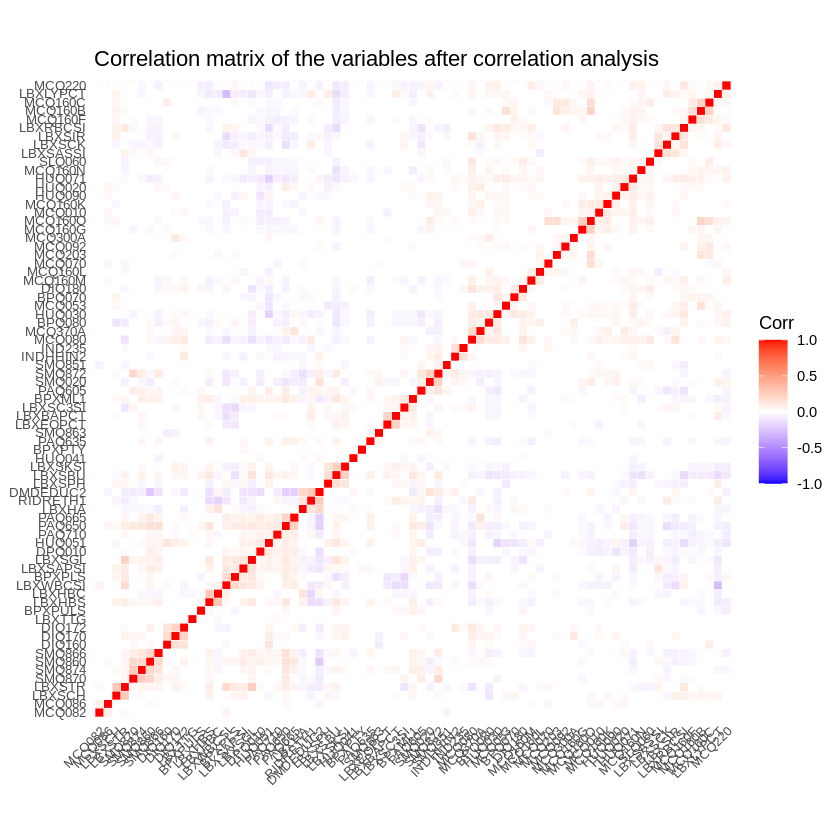

In [ ]:
                                ############## Correlation analysis #################

p.mat <- cor_pmat(curated_data) #matrix with the pvalues of the correlation
cor <- cor(curated_data) #correlation matrix
ggcorrplot(cor, hc.order = TRUE, outline.col = "white", tl.cex = 8, #plot of the correlation matrix
            p.mat = p.mat, , insig = "blank", title = "Correlation matrix of the variables before correlation analysis")

top_pairs <- cor %>% #retrieve the correlation pairs in descending order
  as.data.frame() %>%
  mutate(var1 = rownames(.)) %>%
  gather(var2, value, -var1) %>%
  arrange(desc(abs(value))) %>%
  group_by(value) %>%
  filter(row_number()==1)

correlated_variables <- top_pairs %>% #get one of the variable if the pair has an absolute correlation of more than 0.3
  filter(abs(value) > 0.3) %>%
  pull(var1)

curated_data <- curated_data[, -match(correlated_variables, names(curated_data))] #remove it from the data set

p.mat <- cor_pmat(curated_data) #inspect the new correlation matrix
cor <- cor(curated_data)
ggcorrplot(cor, hc.order = TRUE, outline.col = "white", tl.cex = 8,
            p.mat = p.mat, , insig = "blank", title = "Correlation matrix of the variables after correlation analysis")

cat("The dimensions of the dataset after the correlation step is", dim(curated_data))

In [ ]:
                                ################# Deletion of constant values ###################
constant_variables <- c()

for (variable in colnames(curated_data)) {
  lower_bound <- quantile(curated_data[, variable], 0.025)
  upper_bound <- quantile(curated_data[, variable], 0.075)
  if (abs(lower_bound - upper_bound) < 0.1) {
    constant_variables <- c(constant_variables, variable)
  }
}

curated_data <- curated_data[, -match(constant_variables, names(curated_data))]
selected_columns <- colnames(curated_data)
cat("Selected variables :", selected_columns, "
")
cat("The dimensions of the dataset after the constant variable deletion is", dim(curated_data))

Selected variables : LBXSAPSI LBXSASSI LBXSBU LBXSC3SI LBXSCH LBXSCK LBXSGL LBXSIR LBXSKSI LBXSPH LBXSTR LBXWBCSI LBXLYPCT LBXEOPCT LBXBAPCT LBXRBCSI LBXHBC DMDEDUC2 INDHHIN2 DIQ160 IND235 MCQ053 MCQ070 MCQ160N MCQ160B MCQ160C MCQ160F MCQ160K MCQ160L MCQ160O MCQ203 BPXPLS BPXML1 
The dimensions of the dataset after the constant variable deletion is 4408 33

#Classification Model

We aim to predict if a patient will have coronary heart disease (CHD) using hematological data including the amount of:
*   Metabolites (cholesterol, triglycerides, glucose)
*   Blood cell count (white blood cells, red blood cells, lymphocytes, eosinophils, basophils)




In [ ]:
variable_of_interest <- "MCQ160C"
predictors <- c("LBXSCH", "LBXSGL", "LBXSTR", "LBXWBCSI", "LBXLYPCT", "LBXEOPCT", "LBXBAPCT", "LBXRBCSI", "IND235")
selected_columns <- c(variable_of_interest, predictors)
selected_data <- curated_data[, match(selected_columns, names(curated_data))]
head(selected_data)

,MCQ160C,LBXSCH,LBXSGL,LBXSTR,LBXWBCSI,LBXLYPCT,LBXEOPCT,LBXBAPCT,LBXRBCSI,IND235
,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,2,168,554,140,4.7,42.2,3.4,1.2,5.09,4
2,2,167,219,257,12.6,27.3,6.1,0.6,3.84,5
3,2,127,183,51,7.2,13.9,5.6,0.9,5.53,10
5,2,207,104,88,6.6,20.5,2.4,1.4,4.72,11
6,1,230,104,327,9.4,17.4,5.9,0.9,4.93,10
8,2,167,107,68,5.2,30.2,5.1,0.6,4.66,8


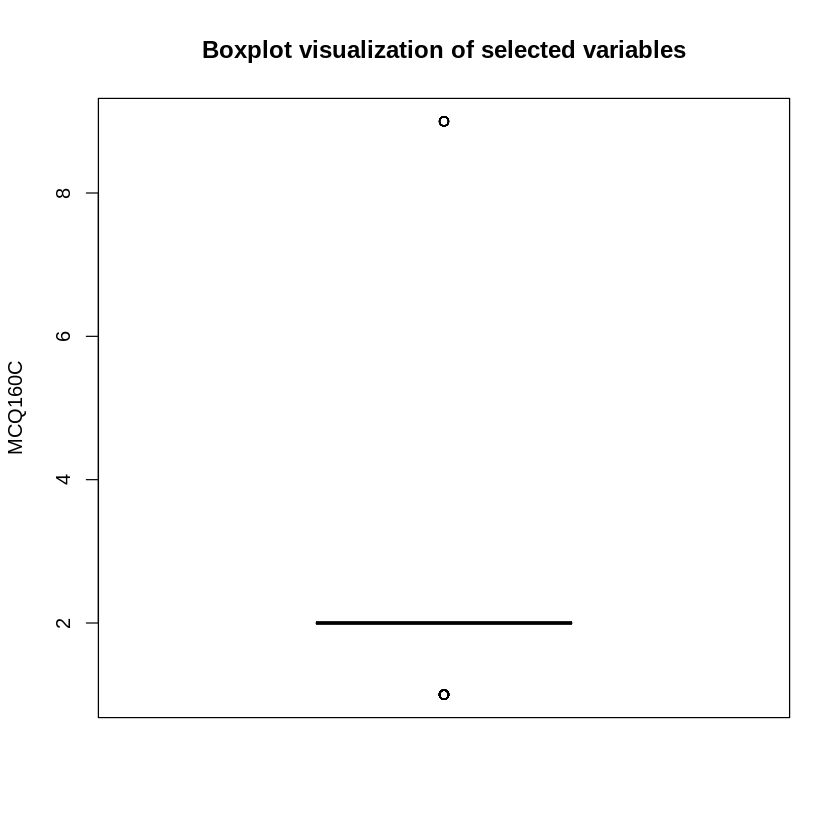

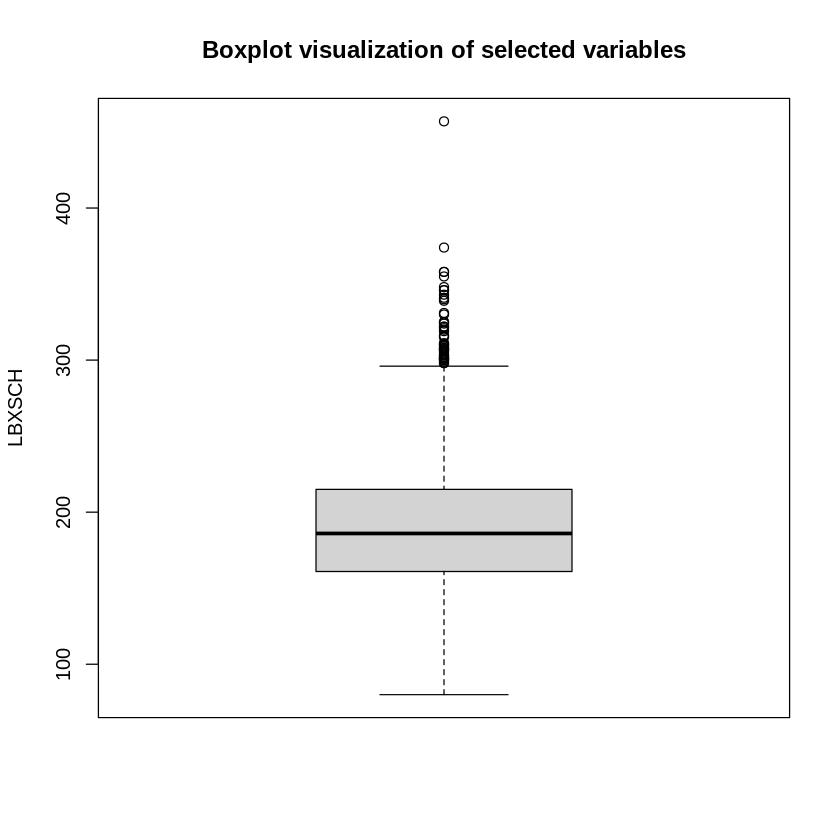

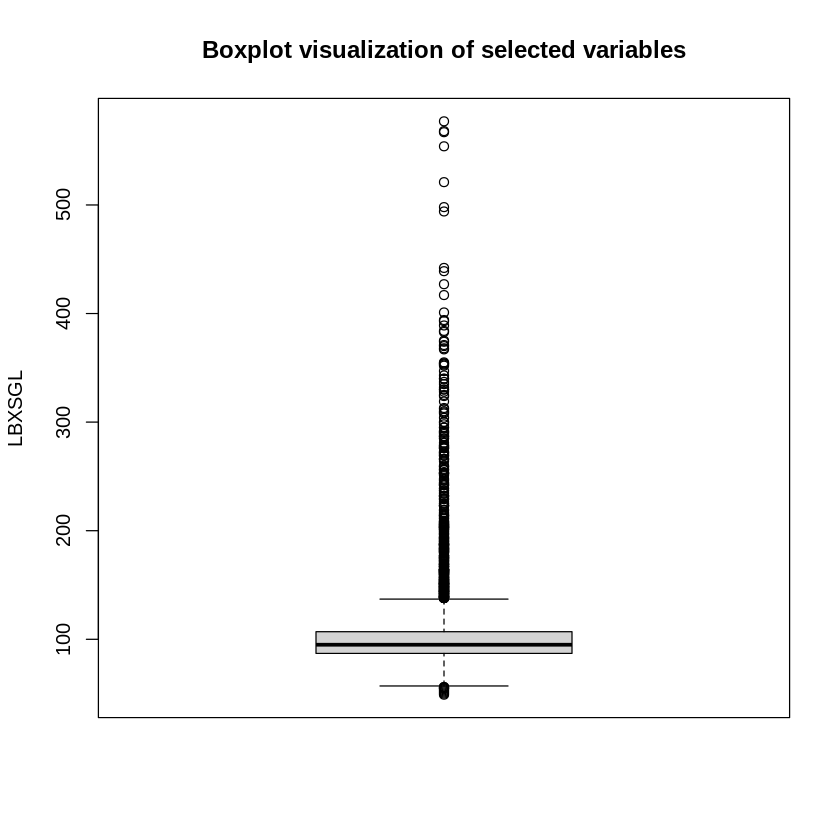

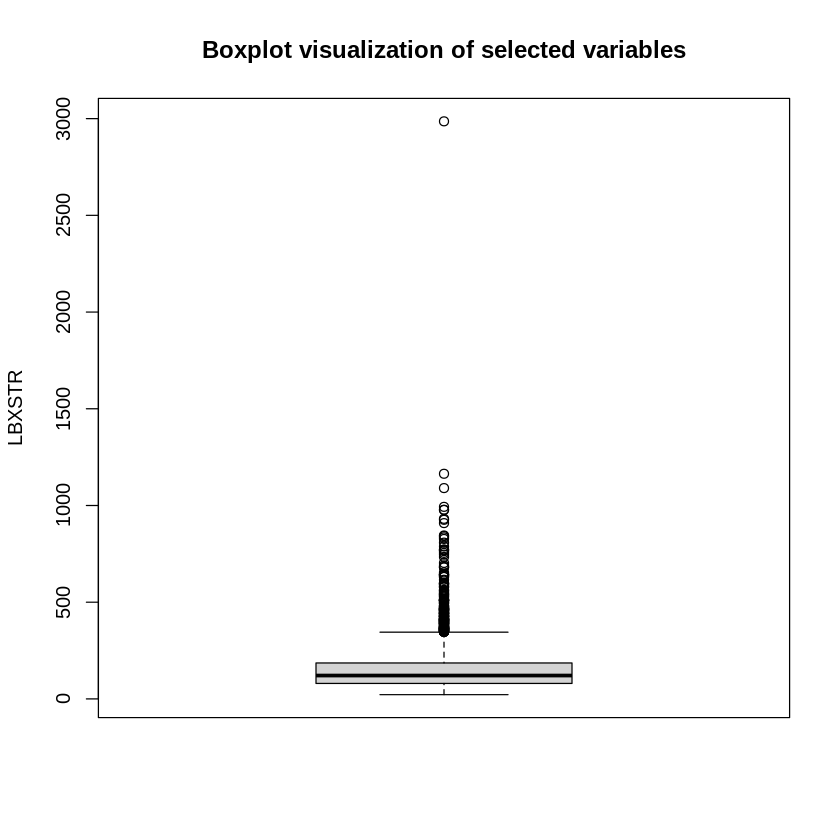

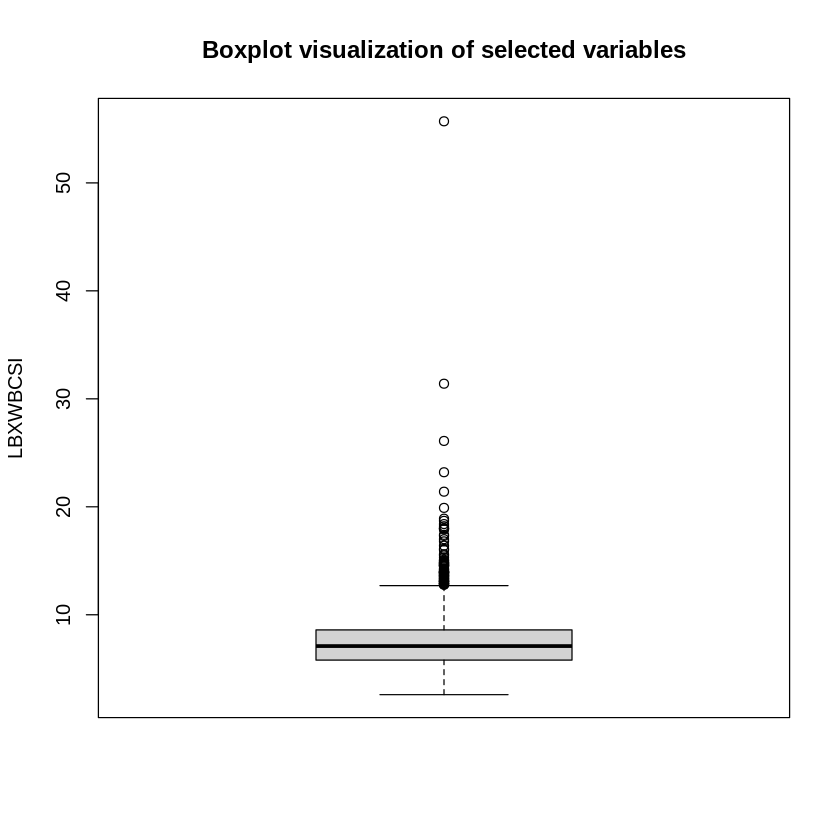

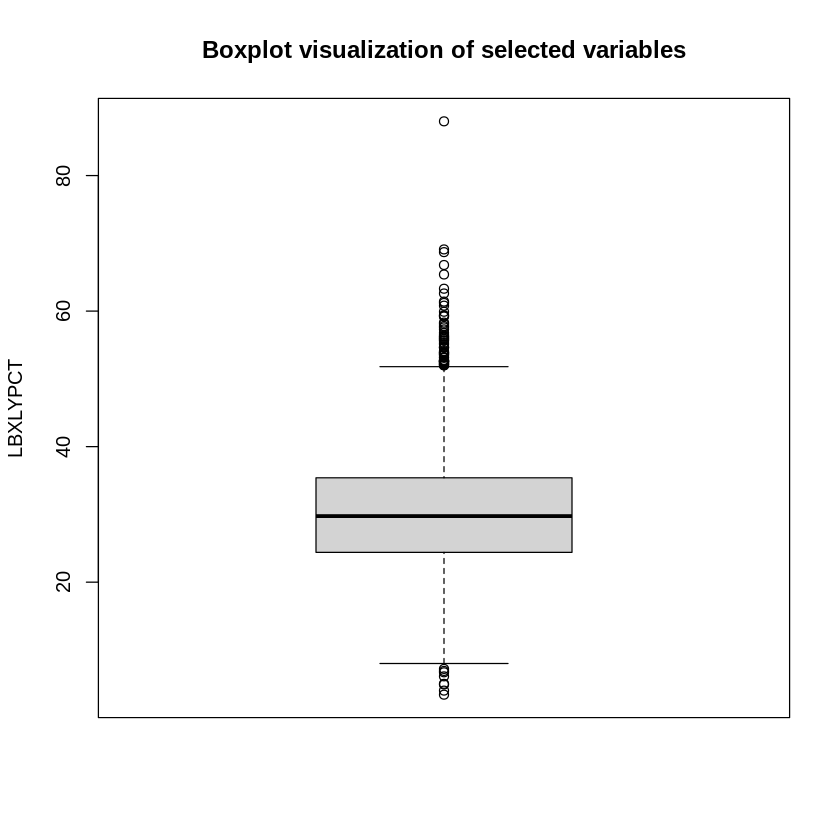

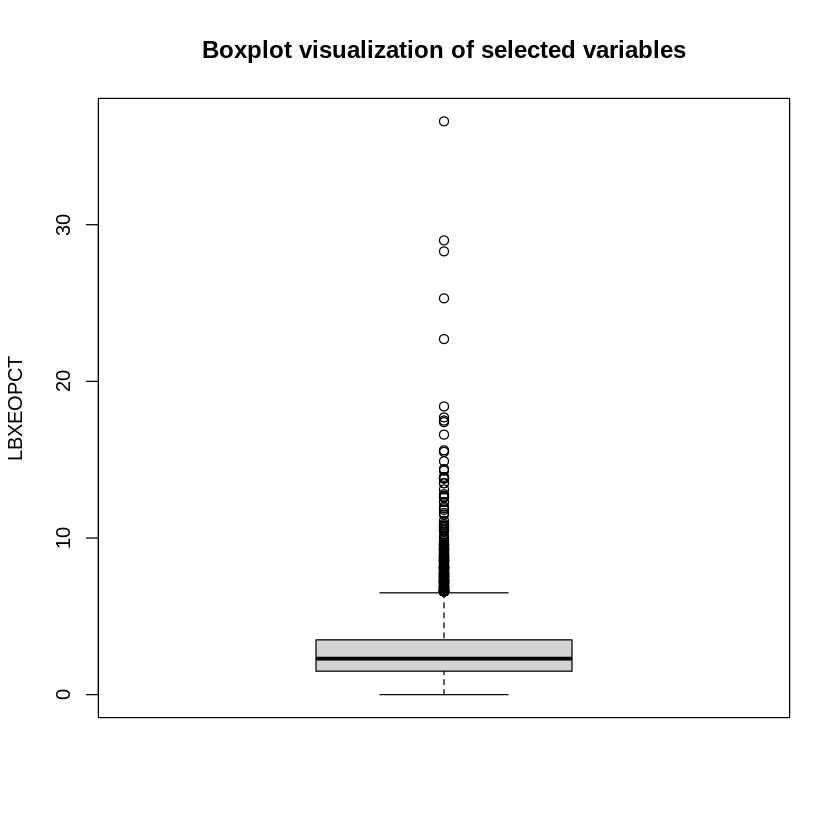

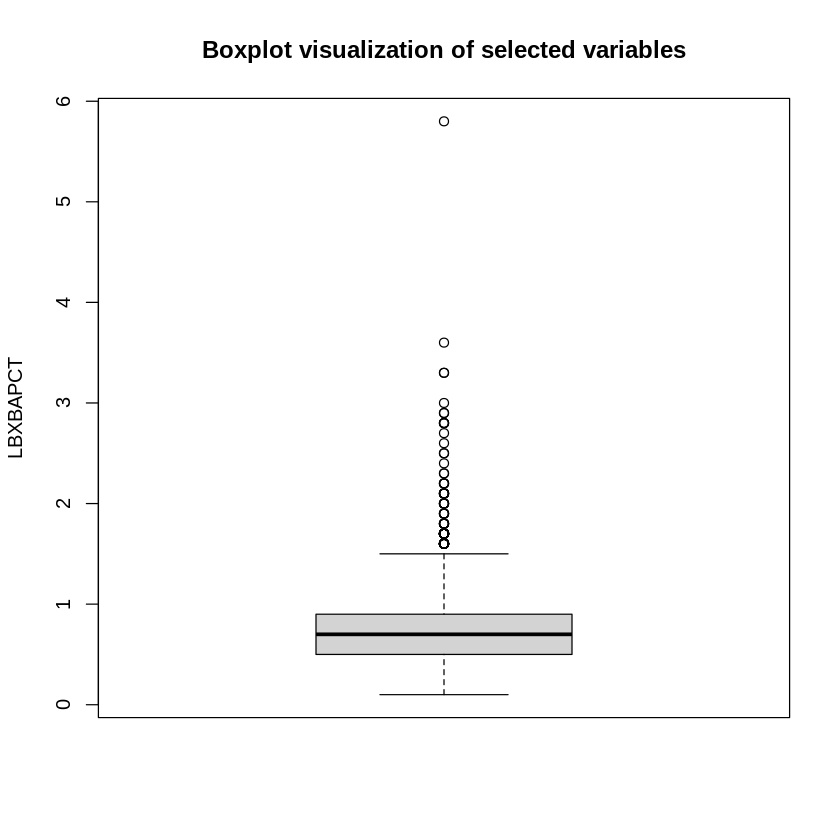

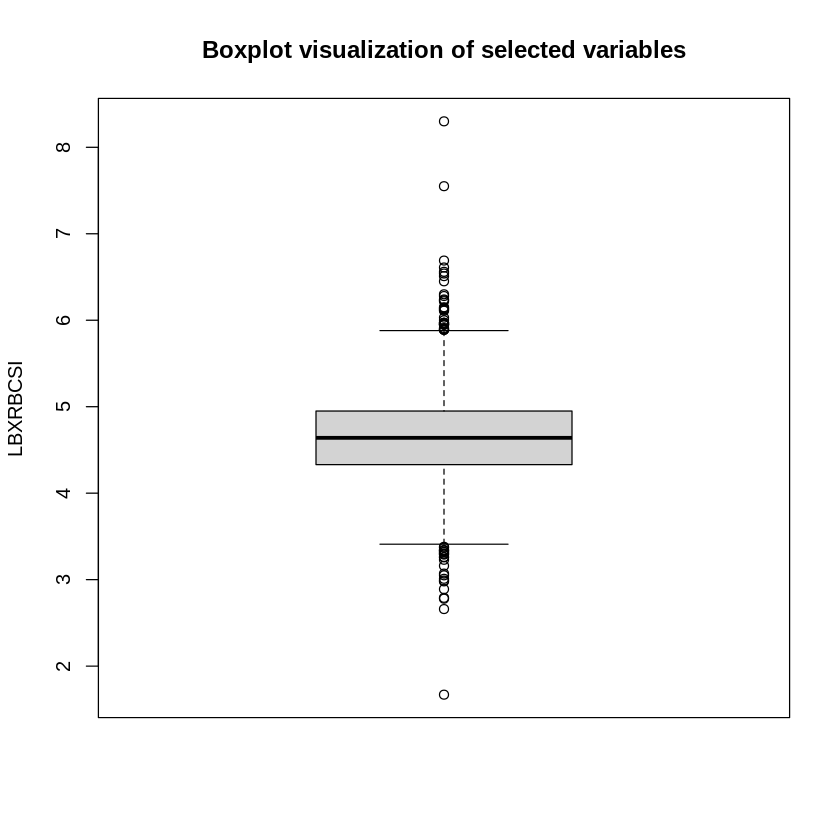

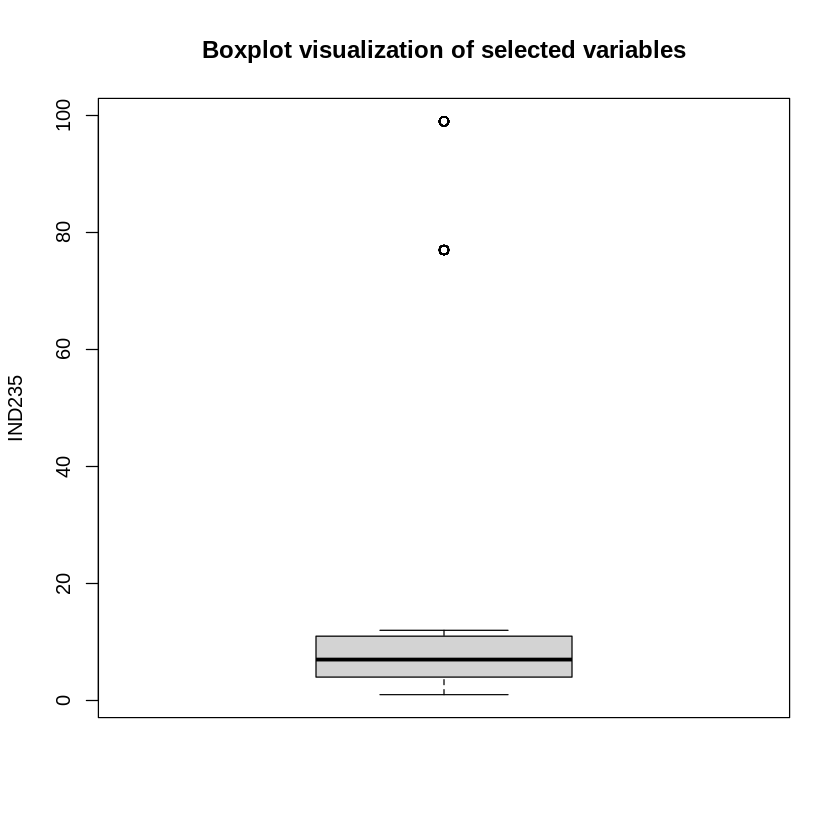

In [ ]:
                                  ############ Visualization of the selected variables ################
for (variable in selected_columns) {
  boxplot(selected_data[,variable],
  ylab = variable,
  main = "Boxplot visualization of selected variables"
)
}

In [ ]:
                                  ########### Make the output binary and take off outliers ############
selected_data$MCQ160C <- case_when(
  selected_data$MCQ160C == 2 ~ 0,
  selected_data$MCQ160C == 1 ~ 1,
  TRUE ~ 0
)
summary(as.factor(selected_data$MCQ160C))

0    1 
4210  198

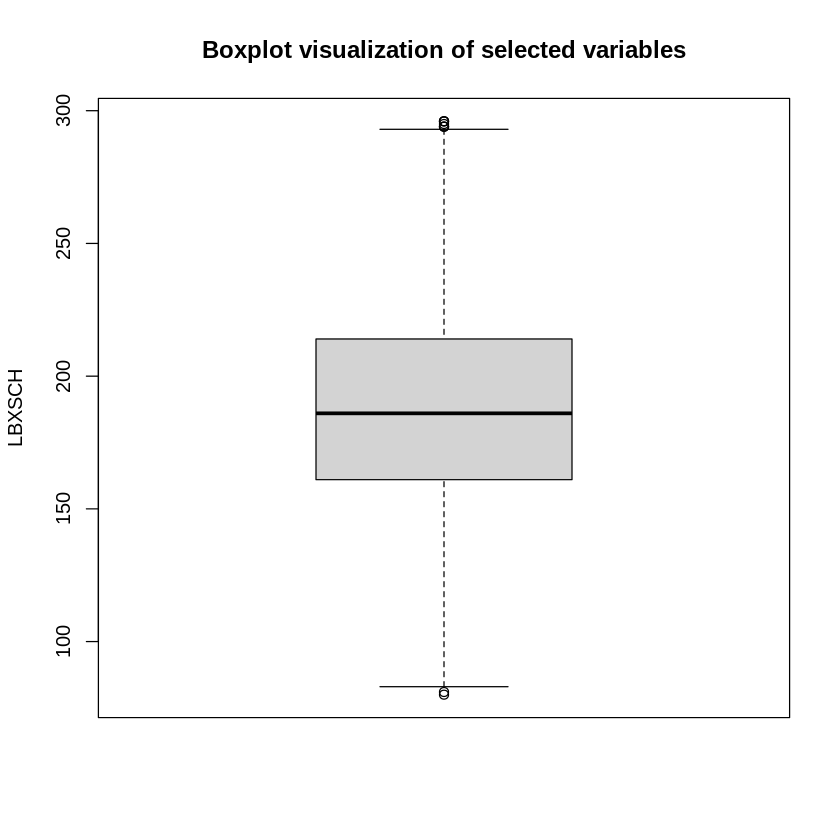

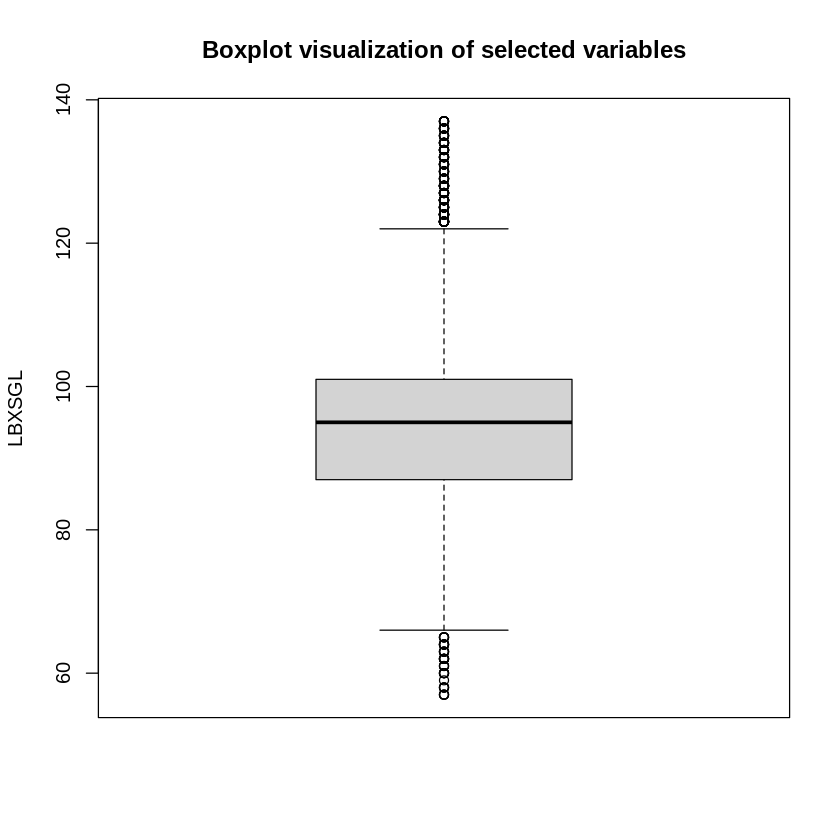

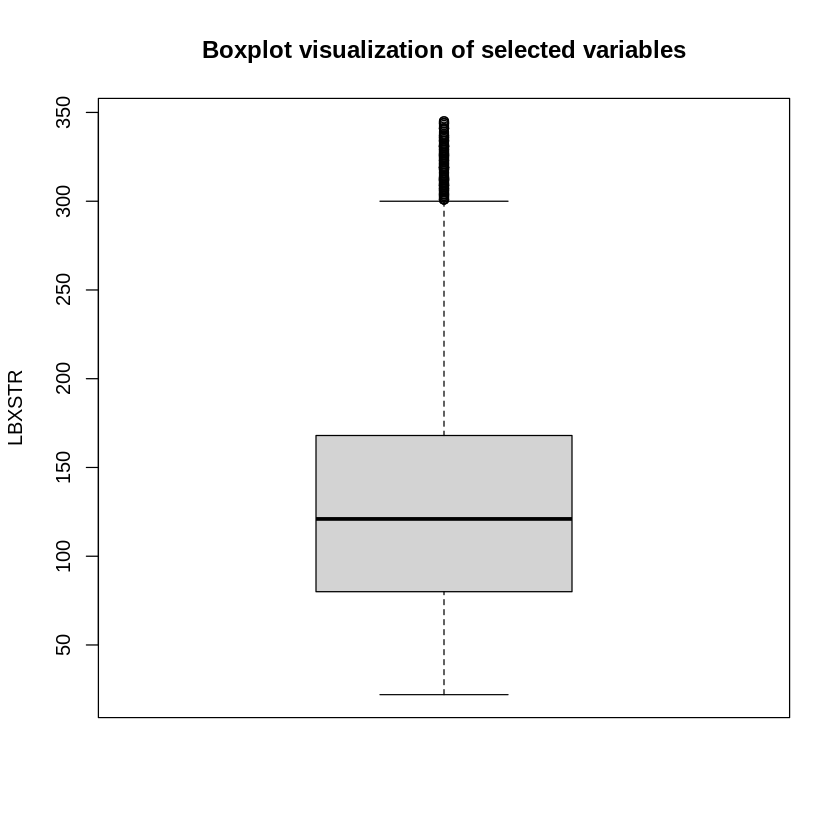

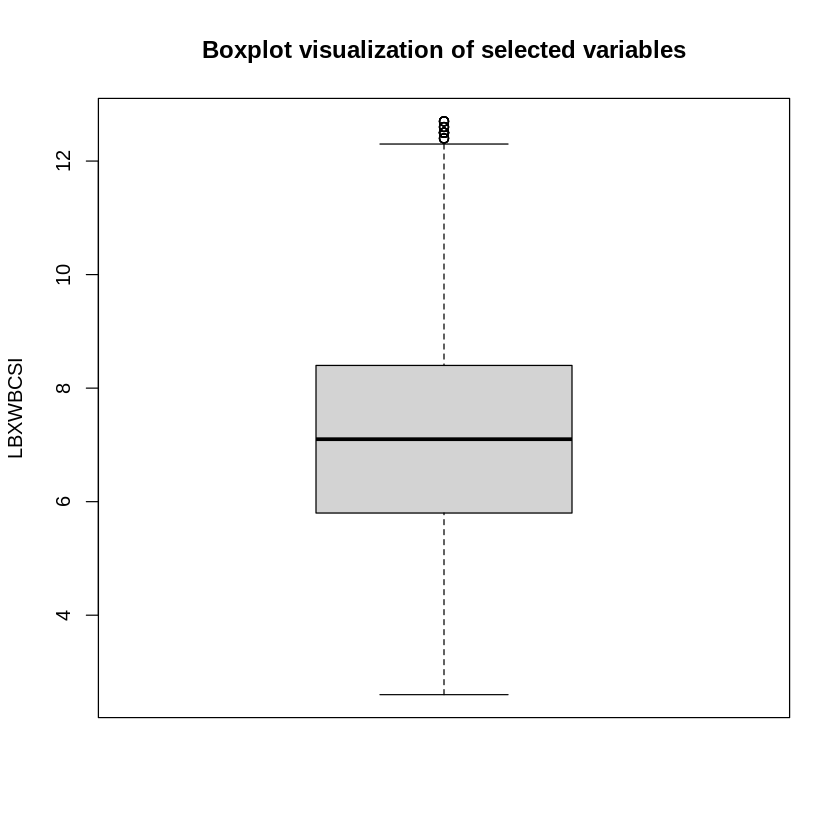

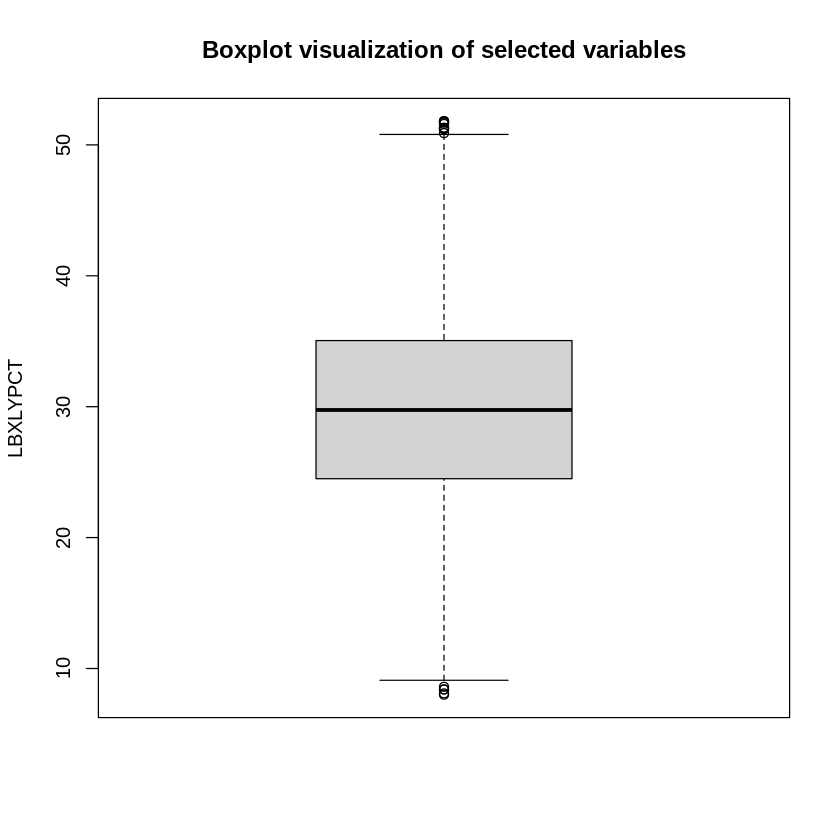

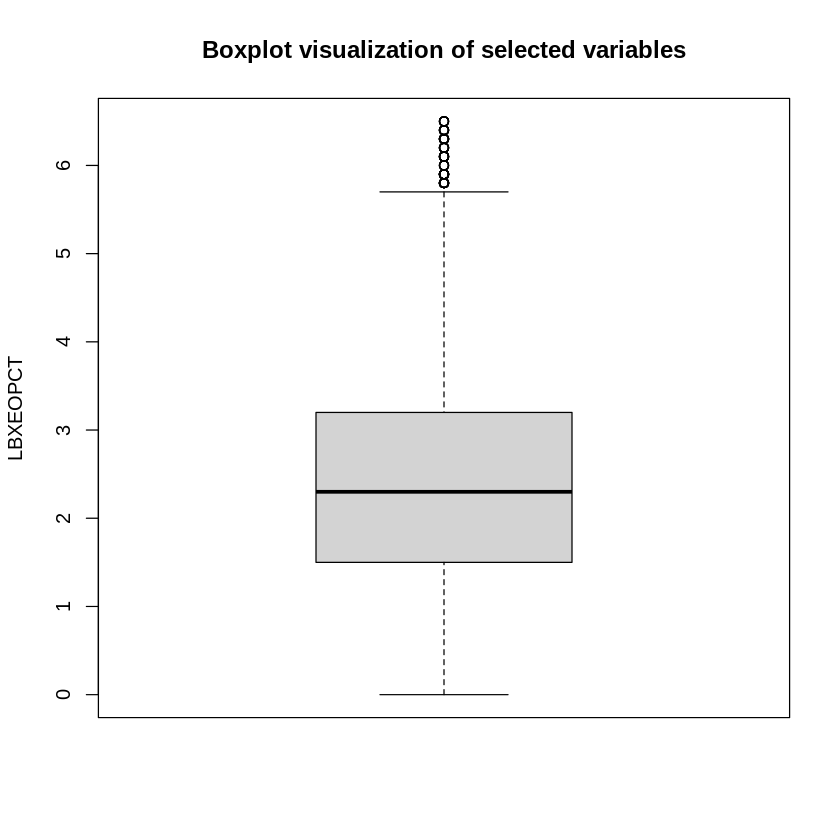

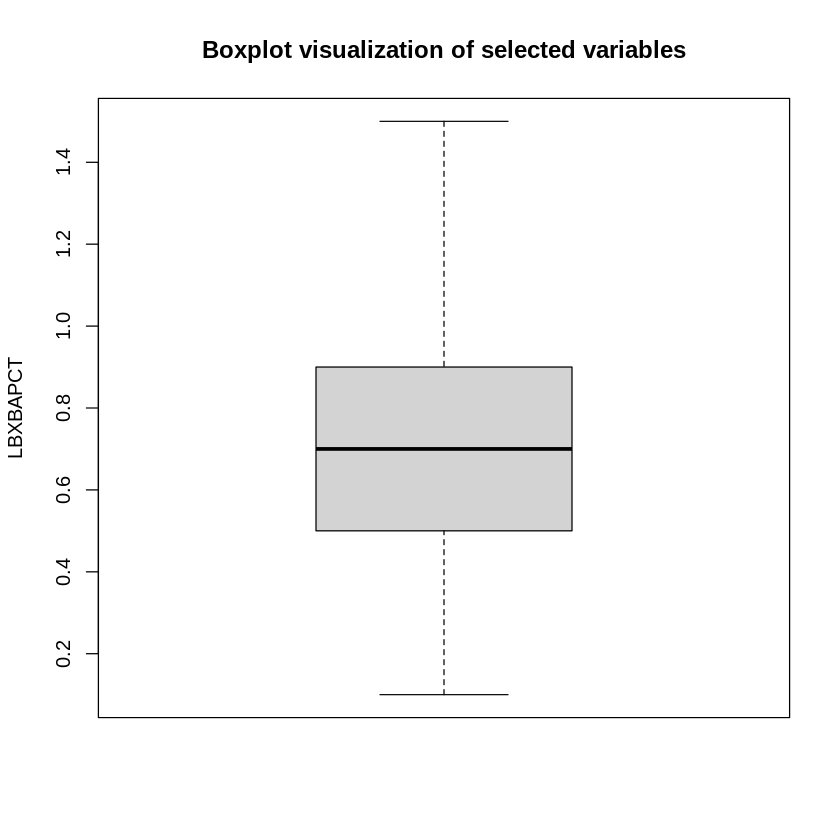

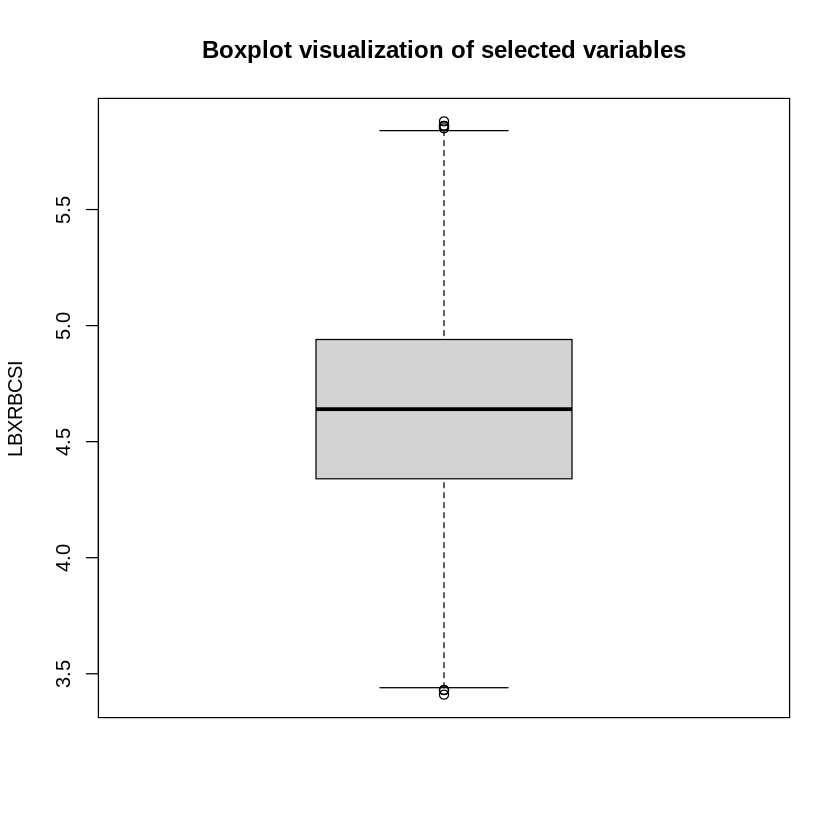

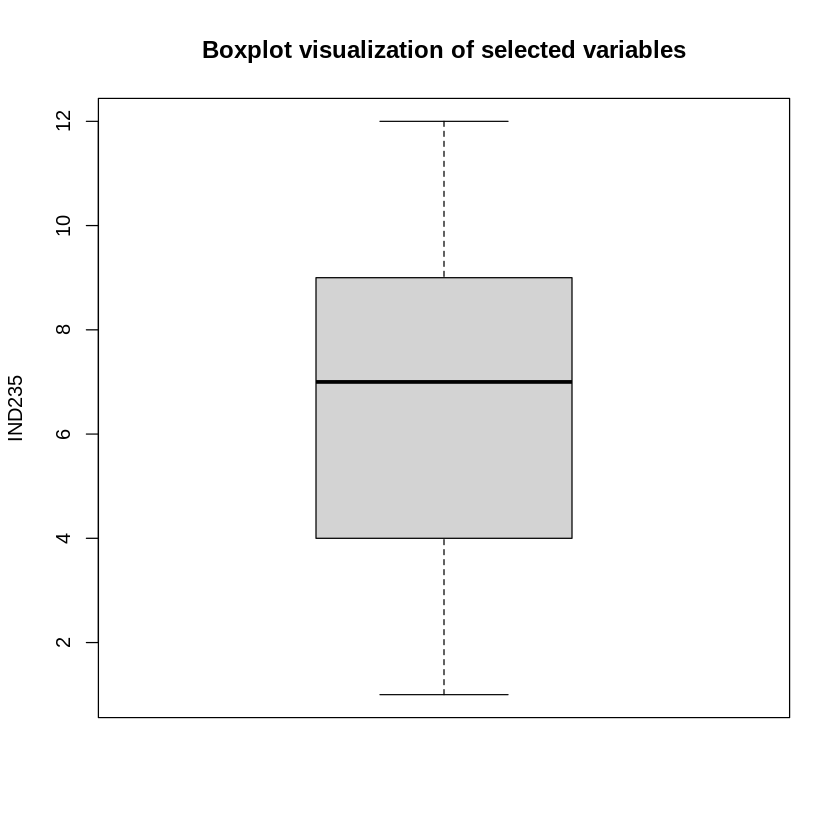

In [ ]:
                                         ########### Correct the outliers #############
for (variable in predictors) {

  q1 <- quantile(selected_data[, variable], 0.25)
  q3 <- quantile(selected_data[, variable], 0.75)
  iqr <- q3 - q1
  threshold <- 1.5 * iqr

  outliers <- which(selected_data[,variable] < (q1 - threshold) | selected_data[,variable] > (q3 + threshold))

  selected_data[outliers, variable] <- median(selected_data[,variable])

  boxplot(selected_data[,variable],
  ylab = variable,
  main = "Boxplot visualization of selected variables"
)
}

#Hypothesis Testing
Because of the known association between social determinants of health and cardiac history, we were curious to know if our dataset also displayed such correlation. Our null hypothesis is that there is no significant difference between CHD diagnosis and socio-economic demographics. Our alternative hypothesis is that there is a statistically significant difference between CHD diagnosis and socio-economic demographics.

NULL

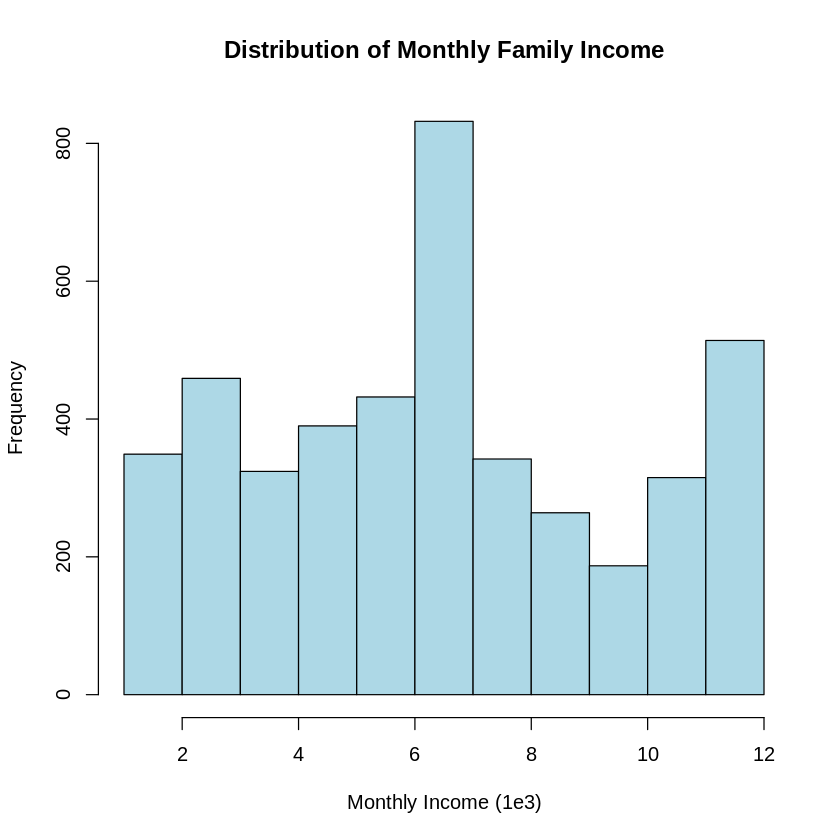

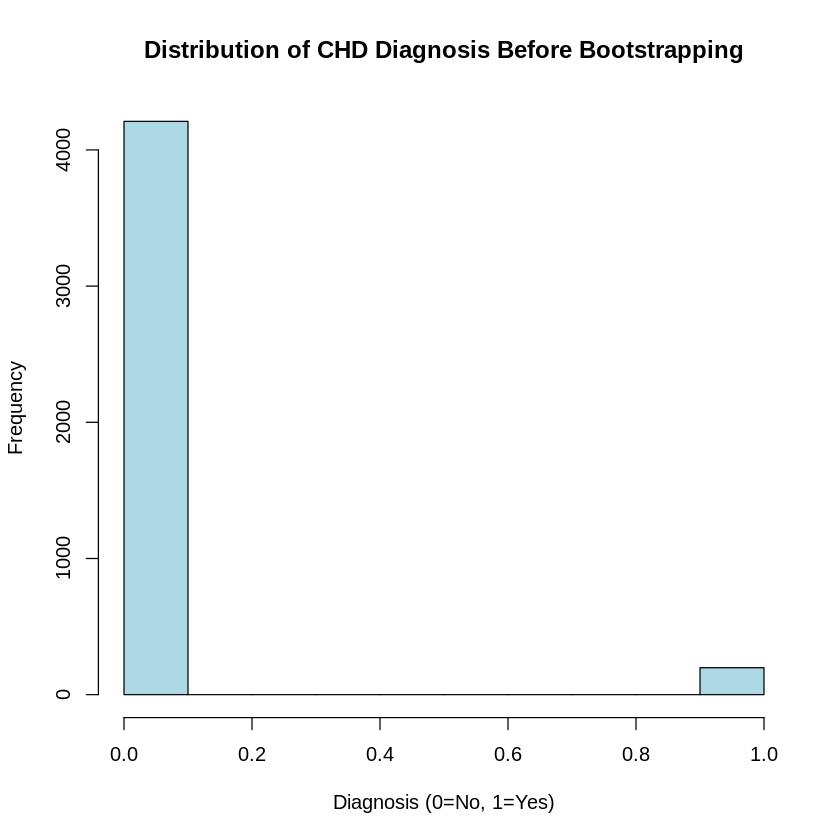

In [ ]:
                                            ########## Visualization of CHD diagnosis & monthly income distributions ##########

# Monthly family income (IND235) distribution
hist(selected_data$IND235, main = "Distribution of Monthly Family Income", xlab = "Monthly Income (1e3)", ylab = "Frequency", col = "lightblue", border = "black") +
  scale_y_continuous(labels = label_number(scale = 1e-3, suffix = "K"))

# CHD diagnosis (MCQ160C) distribution
hist(selected_data$MCQ160C, main = "Distribution of CHD Diagnosis Before Bootstrapping", xlab = "Diagnosis (0=No, 1=Yes)", ylab = "Frequency", col = "lightblue", border = "black")

In [ ]:
                                            ########## Oversampling and hypothesis testing of CHD diagnosis #########
# Oversample CHD diagnosis because of class imbalance
sampled_CHD <- ovun.sample(MCQ160C ~ ., data = selected_data, method = "both", N = nrow(selected_data), seed=123)$data

# Run a Mann-Whitney U test (Wilcoxon rank sum)
wilcox_result <- wilcox.test(sampled_CHD$MCQ160C, sampled_CHD$IND235)
wilcox_result


	Wilcoxon rank sum test with continuity correction

data:  sampled_CHD$MCQ160C and sampled_CHD$IND235
W = 101882, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0
